# 1. 데이터 준비

In [1]:
import pandas as pd

In [3]:
df_original = pd.read_excel(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx',
    engine = 'openpyxl'
)
df = df_original.copy()

In [4]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


# 2. EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [9]:
print(df.isnull().sum().sort_values(ascending= False))
print()
print("Description 결측치 개수 : ", len(df[df['Description'].isnull()]))
print("Description, Price 동시 결측치 개수 : ", len(df[(df['Description'].isnull()) & (df['Price'] == 0.0)]))

Customer ID    107927
Description      2928
Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64

Description 결측치 개수 :  2928
Description, Price 동시 결측치 개수 :  2928


In [10]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


# 3. 데이터 전처리

In [12]:
# @title 3-1 이상치 제거
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]
df = df.drop_duplicates()

In [13]:
#@title RFM 지표
import datetime 
import numpy as np

last_date = df['InvoiceDate'].max() + datetime.timedelta(days = 1)
df['Amount'] = df['Quantity'] * df['Price']

In [15]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate' : lambda InvoiceDate: (last_date - InvoiceDate.max()).days,
    'Invoice' : lambda Invoice: Invoice.nunique(),
    'Amount' : lambda Amount: Amount.sum()
    })
rfm.columns = ['Recency','Frequency','Monetary']
rfm.head(5)

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In [25]:
rfm['Recency_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['Frequency_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['Monetary_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['customer_score'] = rfm['Recency_score'] + rfm['Frequency_score'] + rfm['Monetary_score']

In [33]:
rfm.columns

Index(['Recency', 'Frequency', 'Monetary', 'Recency_score', 'Frequency_score',
       'Monetary_score', 'customer_score'],
      dtype='object')

In [34]:
def level(score):
    if score > 12:
        return 'VIP'
    elif 9 < score <= 12:
        return 'GOLD'
    elif 5 < score <= 9:
        return 'SILVER'
    else:
        return 'GARBAGE'

rfm['customer_level'] = rfm['customer_score'].apply(lambda x : level(x))

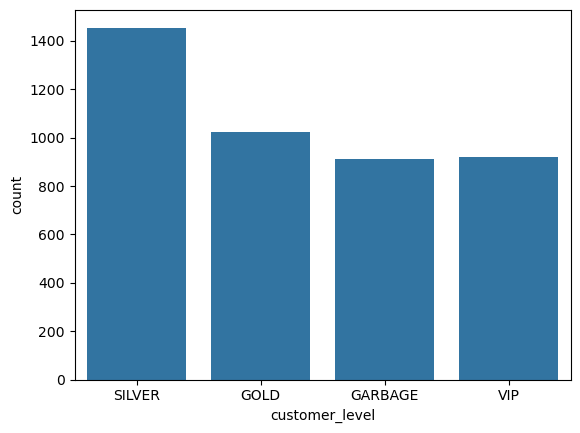

In [40]:
import seaborn as sns

sns.countplot(x=rfm['customer_level'])
plt.show()

# 3. K-means 사용해 고객 분류

In [92]:
###############rfm_original = rfm.copy()
rfm.describe()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,customer_score
count,13.000000,13.000000,13.000000,13.0,13.000000,13.000000,13.000000
mean,340.307692,2.230769,1650.012385,1.0,2.076923,3.615385,6.692308
std,23.952678,1.589227,1622.448272,0.0,1.115164,0.650444,1.601282
min,315.000000,1.000000,658.950000,1.0,1.000000,3.000000,5.000000
25%,318.000000,1.000000,875.970000,1.0,1.000000,3.000000,5.000000
50%,332.000000,2.000000,1142.880000,1.0,2.000000,4.000000,7.000000
75%,365.000000,2.000000,1807.980000,1.0,3.000000,4.000000,7.000000
max,374.000000,6.000000,6798.720000,1.0,4.000000,5.000000,10.000000


In [99]:
def processing_outlier(df, col_nm):
    Q1 = df[col_nm].quantile(0.25)
    Q3 = df[col_nm].quantile(0.75)
    IQR = Q3-Q1

    df = df[(df[col_nm] >= Q1 - IQR*1.5) & (df[col_nm] <= Q3 + IQR*1.5)]

    return df

In [100]:
rfm = rfm_original.copy()
rfm.shape

(4312, 8)

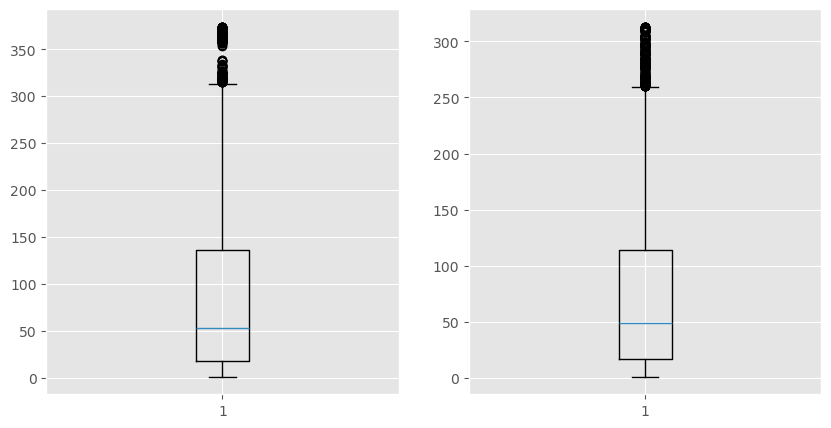

(4135, 8)


In [101]:
rfm = processing_outlier(rfm, 'Recency')

fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1,2,1)
b = fig.add_subplot(1,2,2)

a.boxplot(rfm_original['Recency'])
b.boxplot(rfm['Recency'])

plt.show()
print(rfm.shape)

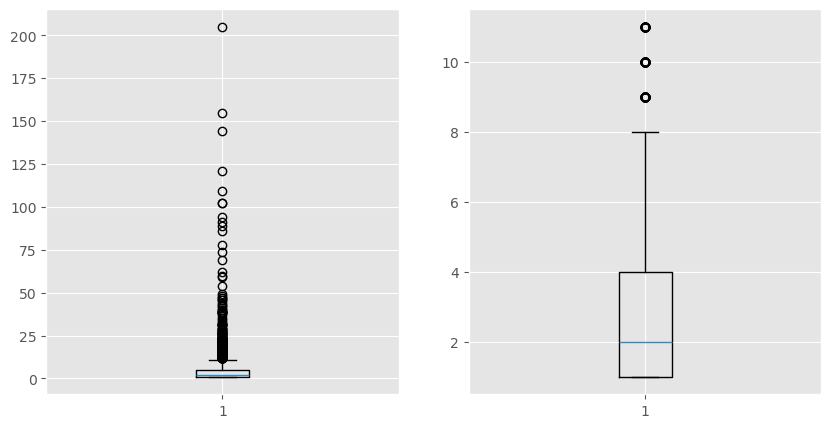

In [102]:
rfm = processing_outlier(rfm, 'Frequency')

fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1,2,1)
b = fig.add_subplot(1,2,2)

a.boxplot(rfm_original['Frequency'])
b.boxplot(rfm['Frequency'])

plt.show()

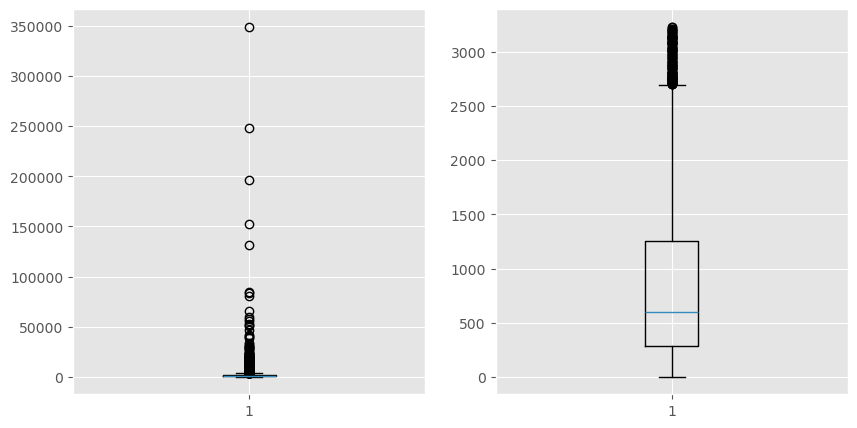

In [103]:
rfm = processing_outlier(rfm,'Monetary')

fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1,2,1)
b = fig.add_subplot(1,2,2)

a.boxplot(rfm_original['Monetary'])
b.boxplot(rfm['Monetary'])

plt.show()

In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train = rfm[['Recency','Frequency','Monetary']]
train_scaled = scaler.fit_transform(train)

print(train)
print(train_scaled)

             Recency  Frequency  Monetary
Customer ID                              
12346.0          165         11    372.86
12347.0            3          2   1323.32
12348.0           74          1    222.16
12349.0           43          3   2671.14
12351.0           11          1    300.93
...              ...        ...       ...
18283.0           18          6    619.37
18284.0           67          1    461.68
18285.0          296          1    427.00
18286.0          112          2   1296.43
18287.0           18          4   2345.71

[3579 rows x 3 columns]
[[ 0.9212283   3.66836645 -0.65156008]
 [-1.00622537 -0.39944379  0.61914885]
 [-0.16147716 -0.8514227  -0.85303709]
 ...
 [ 2.47984824 -0.8514227  -0.57917809]
 [ 0.2906416  -0.39944379  0.5831985 ]
 [-0.82775744  0.50451404  1.98602394]]


# 4. 모델 학습

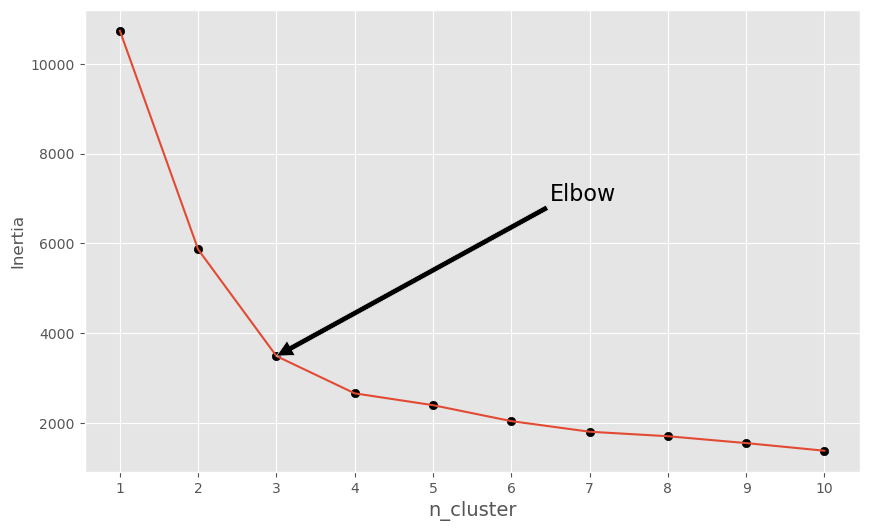

In [106]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

clusters = range(1,11)
inertias = []
for n in clusters:
    model = KMeans(n_clusters=n, random_state = 1)
    model.fit(train_scaled)
    inertias.append(model.inertia_)

plt.subplots(figsize=(10,6))
plt.plot(clusters, inertias)
plt.scatter(x=clusters, y=inertias, c='black')
plt.annotate('Elbow',
            xy=(3,inertias[2]),
            xytext = (0.55,0.55),
            textcoords = 'figure fraction',
            fontsize=16,
            arrowprops=dict(facecolor='black', shrink=1))


plt.xlabel('n_cluster', fontsize=14)
plt.ylabel('Inertia')
plt.xticks(clusters)

plt.style.use('ggplot')

plt.show()

In [119]:
model = KMeans(3, random_state = 1)

result = train.copy()
result['cluster_pred'] = model.fit_predict(train_scaled)
print("centers :", model.cluster_centers_)
result

centers : [[-0.45377493 -0.3636411  -0.38590848]
 [ 1.58504646 -0.60597004 -0.5930881 ]
 [-0.54703967  1.38120633  1.41730338]]


,Recency,Frequency,Monetary,cluster_pred
Customer ID,,,,
12346.0,165,11,372.86,2
12347.0,3,2,1323.32,0
12348.0,74,1,222.16,0
12349.0,43,3,2671.14,2
12351.0,11,1,300.93,0
...,...,...,...,...
18283.0,18,6,619.37,2
18284.0,67,1,461.68,0
18285.0,296,1,427.00,1


<Axes: xlabel='cluster_pred', ylabel='count'>

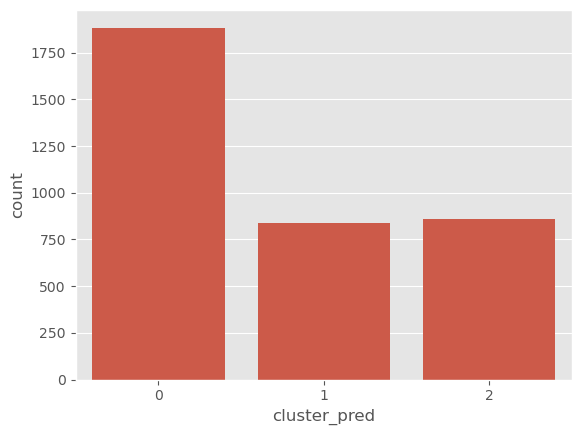

In [120]:
sns.countplot(x = 'cluster_pred', data = clusters_scaled)

In [121]:
result.groupby(['cluster_pred']).count()

,Recency,Frequency,Monetary
cluster_pred,,,
0,1885,1885,1885
1,836,836,836
2,858,858,858


# 5. 결과

In [126]:
train['cluster'] = result['cluster_pred']
train['level'] = rfm['customer_level']
train

,Recency,Frequency,Monetary,cluster,level
Customer ID,,,,,
12346.0,165,11,372.86,2,SILVER
12347.0,3,2,1323.32,0,GOLD
12348.0,74,1,222.16,0,GARBAGE
12349.0,43,3,2671.14,2,GOLD
12351.0,11,1,300.93,0,SILVER
...,...,...,...,...,...
18283.0,18,6,619.37,2,GOLD
18284.0,67,1,461.68,0,SILVER
18285.0,296,1,427.00,1,GARBAGE


In [128]:
train.groupby('cluster').agg({
    'Recency' : ['mean','min','max'],
    'Frequency' : ['mean','min','max'],
    'Monetary' : ['mean','min','max','count']
})

Recency           Frequency             Monetary                   \
               mean  min  max      mean min max         mean    min       max   
cluster                                                                         
0         49.396286    1  151  2.082759   1   7   573.156812  10.95  1993.340   
1        220.793062  128  313  1.543062   1   8   416.595648   3.75  2622.481   
2         41.637529    1  270  5.949883   1  11  1923.102684  97.40  3230.450   

               
        count  
cluster        
0        1885  
1         836  
2         858